In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label
from skimage.morphology import convex_hull_image

In [2]:
dimensions = (1000, 600) # for all card templates

# array storing all templates
templates = []

suits = {0: 'clubs', 1: 'diamonds', 2: 'hearts', 3: 'spades'}
ranks = {0: 'A', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '10', 10: 'J', 11: 'Q', 12: 'K'}


In [3]:
# threshAndInvertedThresh functions take an image, and a threshold and return the thresholded image and the inverted thresholded image
def threshAndInvertedThresh(img, t):
	im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	im_threshed = np.where(im_gray > t, 0, 255)

	im_inv = np.where(im_threshed == 255, 0, 255)
	
	return im_threshed, im_inv

#findCardsRegions functions takes and image and returns regions of an area above threshold, these regions are the cards areas 
def findCardsRegions(im, min_area = 0):
	im_threshed, im_inv = threshAndInvertedThresh(im, 150)
	labelled2 = label(im_inv)
	inv_regions = regionprops(labelled2)
	
	# Assuming areas above min_areas represents cards
	cards_identified = np.array([props.bbox for props in inv_regions if props.area > min_area])

	return cards_identified

# getCards extracts card information from cards_identified and reduces image size
def getCards(cards_identified, im_threshed, plot_flag=False):
	cards = []
	if plot_flag:
		plt.figure(figsize=(10,10))
	i = 0
	for card in cards_identified:
		minr, minc, maxr, maxc = card
		card_img = im_threshed[minr-50:maxr+50, minc-50:maxc+50]
		cards.append(card_img)
		#plot
		if(plot_flag):
			plt.subplot(1,len(cards_identified), i+1)
			plt.imshow(card_img, cmap='gray')
			plt.show()
		i+=1
	return cards

# get_line_intersection takes two lines and uses them to calculate the location of the corner where they meet
def get_line_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

In [4]:
# Getting the perspective transformation matrix for using along with warpPerspective to transform image. 
# Takes four correlated points in original and warped domain, so eight equations solved.
def getPerspectiveTransform(sourcePoints, destinationPoints):
    a = np.zeros((8, 8))
    b = np.zeros((8))
    for i in range(4):
        a[i][0] = a[i+4][3] = sourcePoints[i][0]
        a[i][1] = a[i+4][4] = sourcePoints[i][1]
        a[i][2] = a[i+4][5] = 1
        a[i][3] = a[i][4] = a[i][5] = 0
        a[i+4][0] = a[i+4][1] = a[i+4][2] = 0
        a[i][6] = -sourcePoints[i][0]*destinationPoints[i][0]
        a[i][7] = -sourcePoints[i][1]*destinationPoints[i][0]
        a[i+4][6] = -sourcePoints[i][0]*destinationPoints[i][1]
        a[i+4][7] = -sourcePoints[i][1]*destinationPoints[i][1]
        b[i] = destinationPoints[i][0]
        b[i+4] = destinationPoints[i][1]

    x = np.linalg.solve(a, b)
    x.resize((9,), refcheck=False)
    x[8] = 1
    return x.reshape((3,3))


# warpPerspective takes image, transform and output image dimensions as input and gives us a warped image using inverse mapping
def warpPerspective(img, M, dim):
    out = np.zeros(dim, dtype=np.uint8)
    for i in range(dim[0]):
        for j in range(dim[1]):
            x, y, z = np.matmul(M, np.array([i, j, 1]))
            x /= z
            y /= z
            x = int(x)
            y = int(y)
            if(x >= 0 and x < img.shape[1] and y >= 0 and y < img.shape[0]):
                out[i][j] = img[y][x]
    return out

# modify_card takes convex hull of card and modifies it to get a rectangle and ignore insides of card so as to remove noise for hough transform. needed to remove high noise for royal cards. 
def modify_card(card):
    card1 = np.zeros(card.shape, dtype=np.uint8)
    card = cv2.cvtColor(card, cv2.COLOR_GRAY2BGR)

    im_threshed, im_inv = threshAndInvertedThresh(card, 150)
    labelled = label(im_threshed)
    regions = regionprops(labelled)

    max_ind = np.argmax([props.area for props in regions])
    prop = regions[max_ind]
    
    card1 = prop.image
    chull = convex_hull_image(card1).astype(np.uint8)
    card1 = np.zeros(card1.shape, dtype=np.uint8)
    card1[chull == 1] = 255 
    
    card1 = np.pad(chull, 50, 'constant', constant_values=(0))

    card1 = card1*255
    return card1

# Arrange corners finds the first index which is one which is closest to card rank, and then arranges the corners in clockwise order
def arrangeCorners(card, corners, card2, plot_flag=False):
    im_threshed = card.astype(np.uint8)
    labelled = label(im_threshed)
    regions = regionprops(labelled)
    centroids = []
    min_area = 100

    # Centroids of significant regions inside a card like rank, suit symbols, etc.
    centroids = np.array([[props.centroid[1], props.centroid[0]] for props in regions if props.area > min_area])

    mp = {1:(-1,-1), 2:(-1,-1), 3:(-1,-1), 4:(-1,-1)}
    min_dist = im_threshed.shape[0] + im_threshed.shape[1]
    min_i = -1

    # Taking minimum distance between a corner and centroid and assigning said corner as first corner. 
    for i in range(len(corners)):
        for j in range(len(centroids)):
            dist = np.linalg.norm(np.array(corners[i]) - np.array(centroids[j]))
            if(dist < min_dist):
                min_dist = dist
                min_i = i
                
    st = corners[min_i]
    center = np.mean(corners, axis=0)

    # Mapping remaining corners according to cyclic order 
    arctan2 = lambda s, c: angle if (angle := np.arctan2(s, c)) >= 0 else 2 * np.pi + angle

    def clockwise_around_center(point):
        diff = point - center
        rcos = np.dot(diff, center)
        rsin = np.cross(diff, center)
        return arctan2(rsin, rcos)

    # Sort our points using the key function
    sorted_points = sorted(corners, key=clockwise_around_center)

    # find index of st in sorted_points
    st_index = sorted_points.index(st)
    for i in range(4):
        mp[i+1] = sorted_points[(st_index-i+4)%4]

    # Plotting corners with image
    if(plot_flag):
        plt.imshow(card2)
        plt.scatter(mp[1][0], mp[1][1], c='r')
        plt.scatter(mp[2][0], mp[2][1], c='g')
        plt.scatter(mp[3][0], mp[3][1], c='y')
        plt.scatter(mp[4][0], mp[4][1], c='b')
        plt.show()
    return mp 

# Extract Card extracts the card from the hull transformed image and gives a image of constant dimensions containing only cards. 
def extractCard(card, plot_flag=False):
    card = card.astype(np.uint8)
    card1 = modify_card(card)
    edges = cv2.Canny(card1, 100, 200)
    card2 = cv2.cvtColor(card, cv2.COLOR_GRAY2RGB)
    card3 = card2.copy()
    lines = cv2.HoughLines(edges, 1, np.pi/180, 100)
    n2 = 0
    strong_lines = np.zeros([4,1,2])
    for n1 in range(0,len(lines)):
        for rho,theta in lines[n1]:
            if n1 == 0:
                if(rho < 0):
                    rho*=-1
                    theta -= np.pi
                    strong_lines[n2] = [[rho,theta]]
                else: strong_lines[n2] = lines[n1]
                n2 = n2 + 1
            else:
                if rho < 0:
                    rho*=-1
                    theta-=np.pi
                
                closeness_rho = np.isclose(rho,strong_lines[0:n2,0,0],atol = 200)
                closeness_theta = np.isclose(theta,strong_lines[0:n2,0,1],atol = 4*np.pi/36)
                closeness = np.all([closeness_rho,closeness_theta],axis=0)
                if not any(closeness) and n2 < 4:
                    strong_lines[n2] = [[rho,theta]]
                    n2 = n2 + 1

    for line in strong_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 3000*(-b))
        y1 = int(y0 + 3000*(a))
        x2 = int(x0 - 3000*(-b))
        y2 = int(y0 - 3000*(a))
        cv2.line(card2, (x1, y1), (x2, y2), (255, 0, 0), 5)


    
    if(plot_flag):
        plt.imshow(card2)
        plt.show()
    corners = []
    for i in range(len(strong_lines)):
        for j in range(i+1, len(strong_lines)):
            # parallel
            if np.isclose(strong_lines[i][0][1], strong_lines[j][0][1], atol=0.1):
                continue
            inter = get_line_intersection(strong_lines[i][0], strong_lines[j][0])
            if(inter[0] > 0 and inter[1] > 0 and inter[0] < card.shape[1] and inter[1] < card.shape[0]):
                corners.append(inter)

    if(len(corners)!=4):
        return np.zeros((1000,600))

    mp = arrangeCorners(card, corners, card3, plot_flag)
    pts1 = np.float32([mp[1], mp[2], mp[3], mp[4]])
    pts2 = np.float32([[0,0],[0,dimensions[1]-1],[dimensions[0]-1,dimensions[1]-1],[dimensions[0]-1,0]])
    M = getPerspectiveTransform(pts2,pts1)
    dst = warpPerspective(card.astype(np.uint8), M, dimensions)
    return dst

# getIndividualCards outputs an array of images of individual cards from image with multiple cards
def getIndividualCards(crd, plot_flag=False):
    im = cv2.imread(crd)
    im_threshed, img_inv = threshAndInvertedThresh(im, 150)
    cards_identified = findCardsRegions(im, 22000)
    cards = getCards(cards_identified, im_threshed, plot_flag)
    out = []
    for card in (cards):
        card = extractCard(card, plot_flag)
        if(len(np.unique(card))==1):
            continue
        out.append(card)        
    return out

# training is used to train the model for classification of cards
def training():
    for i in range(4):
        for j in range(13):
            im = cv2.imread('../data/training/'+str(ranks[j])+str(suits[i])+'.jpg')
            im_threshed, img_inv = threshAndInvertedThresh(im, 150)
            cards_identified = findCardsRegions(im, 22000)
            cards = getCards(cards_identified, im_threshed)
            card = cards[0]
            card = extractCard(card)
            templates.append((card, str(ranks[j])+str(suits[i])))

# template matching classifies cards on the basis of Minimum Square Error from the training data
def templateMatching(img):
    st = []
    for template in templates:
        mse = np.sum((img.astype("float") - template[0].astype("float")) ** 2)
        template2 = np.rot90(template[0], 2)
        mse2 = np.sum((img.astype("float") - template2.astype("float")) ** 2)
        st.append((min(mse,mse2), template))
    srtSt = sorted(st, key=lambda x: x[0])
    return srtSt[0]

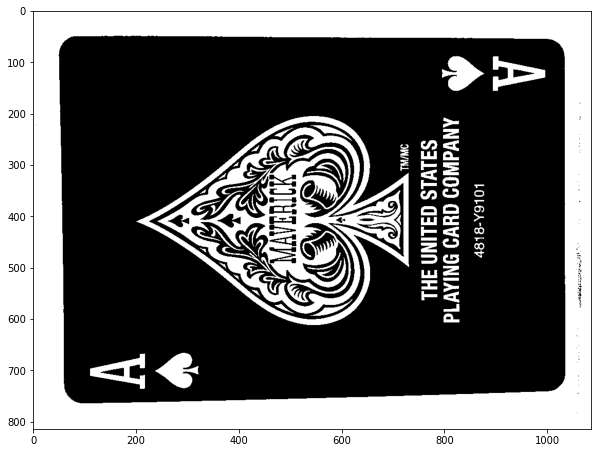

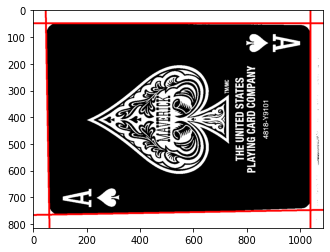

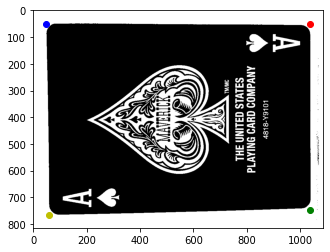

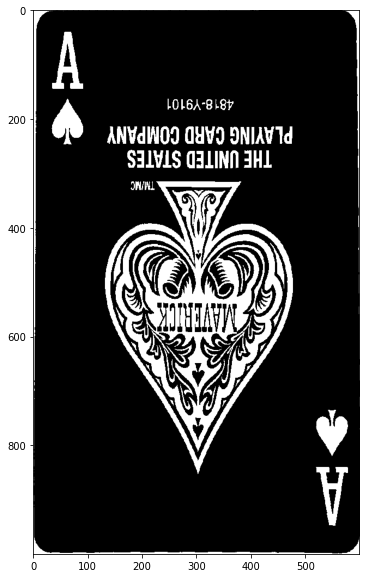

In [5]:
s = '../data/training/Aspades.jpg'
arr = getIndividualCards(s,True)

plt.figure(figsize=(10,10))
for i in range(len(arr)):
    plt.subplot(1,len(arr), i+1)
    plt.imshow(arr[i], cmap='gray')

In [6]:
training()

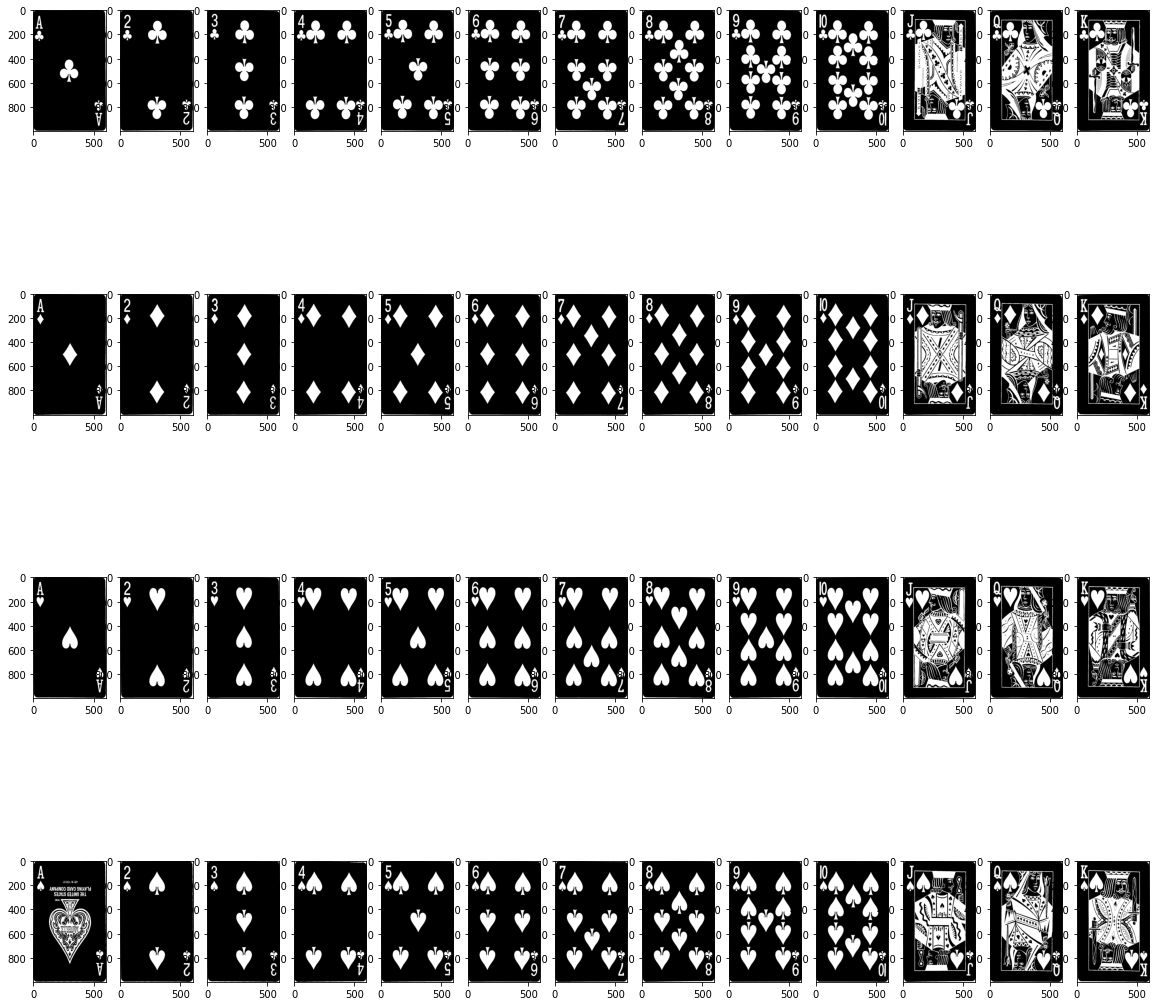

In [7]:
plt.figure(figsize=(20,20))
for i in range(len(templates)):
    plt.subplot(4, 13, i+1)
    plt.imshow(templates[i][0], cmap='gray')

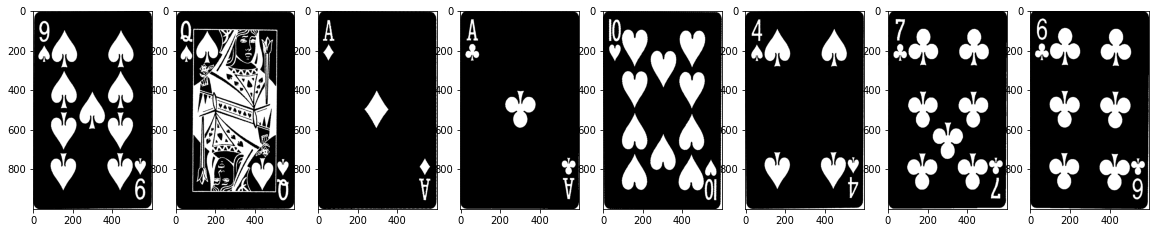

9spades
Qspades
Adiamonds
Aclubs
10hearts
4spades
7clubs
6clubs
----------------------------


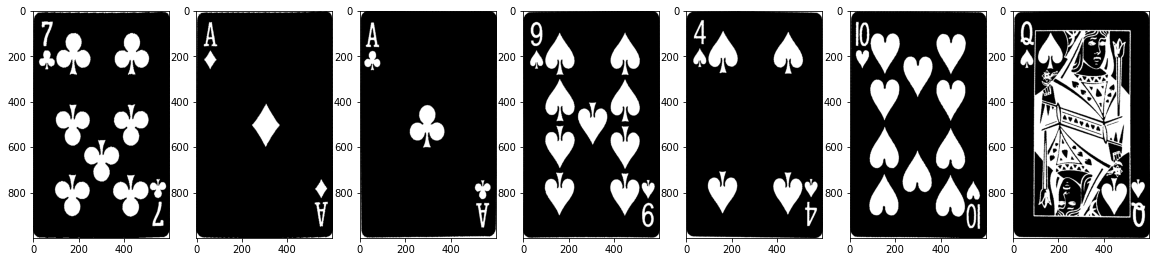

7clubs
Adiamonds
Aclubs
9spades
4spades
10hearts
Qspades
----------------------------


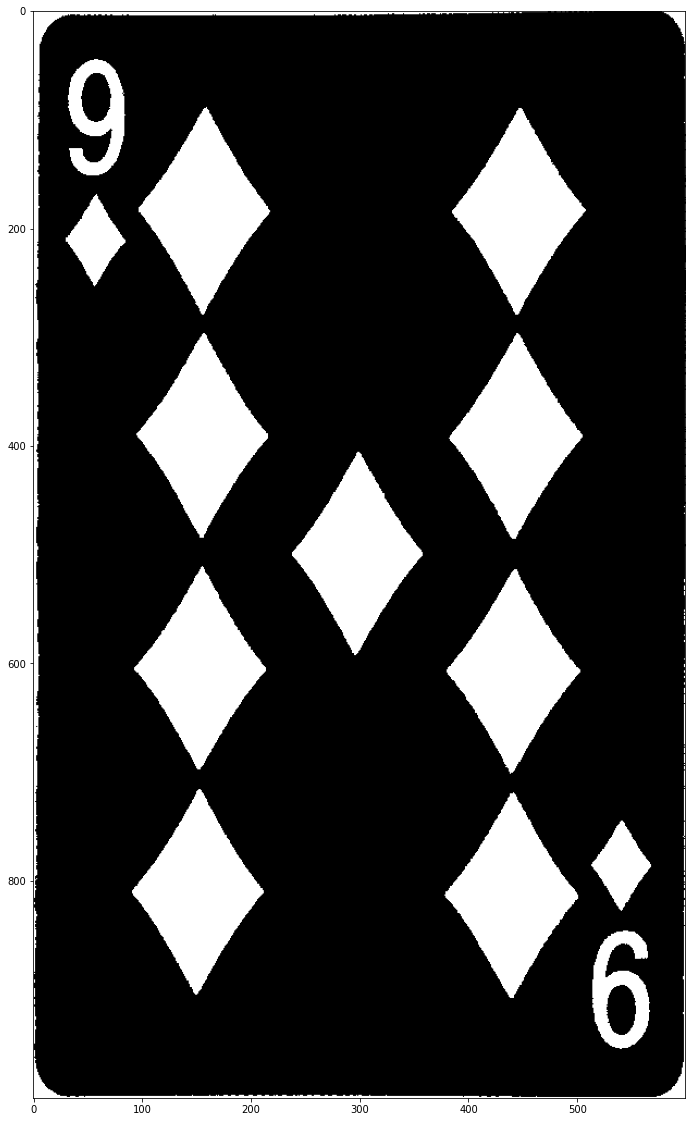

9diamonds
----------------------------


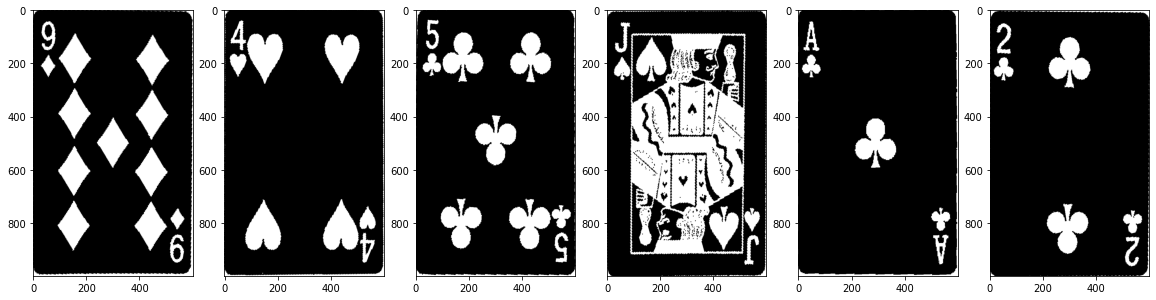

9diamonds
4hearts
5clubs
Jspades
Aclubs
2clubs
----------------------------


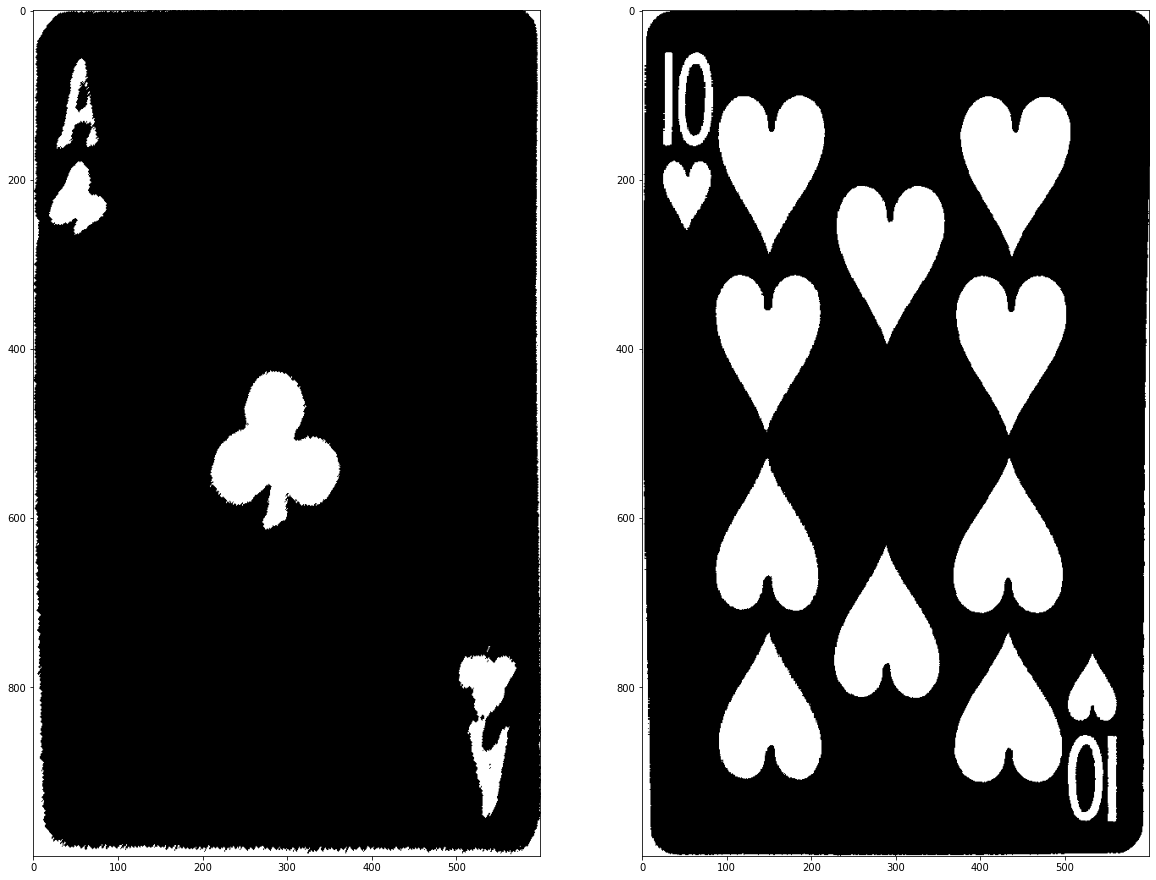

Aclubs
10hearts
----------------------------


In [9]:
array = ['../data/inputs/8cards_top.jpg', '../data/inputs/8card_slight.jpg', '../data/inputs/green_close.jpg', '../data/inputs/green_many.jpg', '../data/inputs/3cards_extreme.jpg']


for s in array:
# s = '../data/inputs/3cards_extreme.jpg'
    arr = getIndividualCards(s)

    plt.figure(figsize=(20,20))
    for i in range(len(arr)):
        plt.subplot(1,len(arr), i+1)
        plt.imshow(arr[i], cmap='gray')
    plt.show()
    for i in range(len(arr)):
        im = arr[i]
        x = templateMatching(im)
        print(x[1][1])
    print("----------------------------")
